# Bayesian Optimisation

## General problem
The main idea is to optimize a black-box function $g$ (for example a neural network with respect to its hyperparameters), in building a probabilistic proxy function which is cheaper to evaluate.

The initial minimization problem is:

\begin{align*}
x_* = \arg \min_{x} g(x)
\end{align*}

Evaluate $g$ is costly, so we will find the global optimum of the proxy function $\tilde g$ and then evaluate the true objective function.

To choose the next point to evaluate the true objective function, a trade-off between exploration (seek place with high variance) and exploitation (seek place with low mean) is made: this is the role of the acquisition function $\alpha$. A gaussian process is then built on the collection of the evaluated points $g(x)$. 

## Acquisition function
We can compute the following, with $\mu(x)$ and $\sigma^2(x)$ the mean and the variance from the GP posterior:

\begin{align*}
\gamma(x) = \frac{g(x_{best}) - \mu(x)}{\sigma(x)}
\end{align*}

From this quantity, several acquisition function can be defined:
- probability of improvement: $\alpha_{PI}(x) = \Phi(\gamma(x))$
- expected improvement: $\alpha_{EI}(x) = \sigma(x)(\gamma(x)\Phi(\gamma(x)) + \mathcal{N}(\gamma(x)|0, 1))$
- GP lower confidence bound: $\alpha_{LCB}(x) = - (\mu(x) - \kappa \sigma(x))$, $\kappa \ge 0$

### Probability of improvement
Determine the probability that $x_*$ leads to a better function  value than the current best one $g(x_{best})$. The idea is to produce $N$ samples function $g_i$, and calculate a Monte-Carlo estimate:

\begin{align*}
\alpha_{PI}(x) = p(g(x) < g(x_{best})) \approx \frac{1}{N} \sum_{i = 1}^{N} \delta (g_i(x) < g(x_{best}))
\end{align*}

The drawback of this method is that it can lead to a continued exploitation in a $\epsilon$-region arround $x_{best}$. So we introduce a slack variable $\xi$ for more aggressive exploration, such that:

\begin{align*}
\gamma(x) = \frac{g(x_{best}) - \xi- \mu(x)}{\sigma(x)}
\end{align*}

### Expected improvement
The amount of improvement is quantified:

\begin{align*}
\alpha_{EI} &= \mathbb{E} (\max ( 0, g(x_{best}) - g(x) ))\\
&\approx \frac{1}{N} \sum_{i=1}^{N}\max ( 0, g(x_{best}) - g(x) )
\end{align*}

For a GP, we have a closed-form solution:

\begin{align*}
\alpha_{EI}(x) = \sigma(x)(\gamma(x)\Phi(\gamma(x)) + \mathcal{N}(\gamma(x)|0, 1))
\end{align*}

### GP lower confidence bound
The idea is to find the lower bound of the GP (built on the evaluations of the true function) by taking the mean and the variance (for example take the 95% confidence interval):

\begin{align*}
\alpha_{LCB}(x) = - (\mu(x) - \kappa \sigma(x))\text{, } \kappa \ge 0
\end{align*}


## Implementation

In [1]:
import GPy
import matplotlib.pyplot as plt
import numpy as np

In the following, we consider the Forrester function:

\begin{align*}
f(x) =(6x-2)^2 \sin(12x-4)\\
x \in [0, 1]
\end{align*}


The minimum of this function is located at $x_{min}=0.78$.

In [2]:
def obj(x):
    return (6*x - 2)**2 * np.sin(12*x - 4)

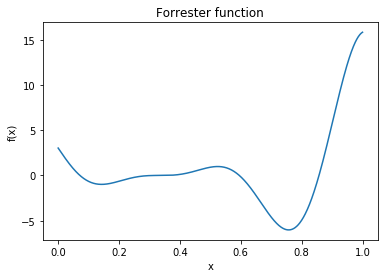

In [3]:
x = np.linspace(0, 1, 1000)
plt.plot(x, obj(x))
plt.title('Forrester function')
plt.xlabel('x')
plt.ylabel('f(x)');

In this simple example, the above function is the black box function: so we have only a few samples from it. Then we fit a GP on it.

In [4]:
def samples(function, n=3, seed=1234, a=0, b=1):
    np.random.seed(seed=seed)
    scale = b-a
    x_init = scale * np.random.rand(n,1) - a

    y_init = function(x_init)
    
    return x_init, y_init

In [5]:
x_0, y_0 = samples(obj, 5)

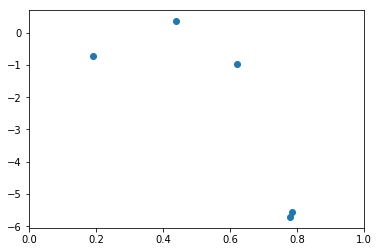

In [6]:
plt.scatter(x_0, y_0)
plt.xlim(0, 1);

In [7]:
kernel = GPy.kern.RBF(1)
gp_model = GPy.models.GPRegression(x_0, y_0, kernel)

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f41d210c390>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f41d2147e80>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f41d210c860>]}

 /usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


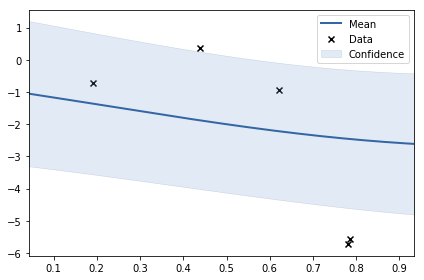

In [8]:
gp_model.plot()